
## </align><center>**NFL 2023 Pass Prediction**</align>


**Hypothesis**: Whether a team will Pass or not in the next play can be predicted better than a majority baseline of 58%

**Source**: http://nflsavant.com open datasets

In [3]:
!pip install shap
!pip install graphviz
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:0000:0100:01


In [4]:
# utilities
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import graphviz

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import shap
shap.initjs()

In [5]:
#Dataframes Source: http://www.nflsavant.com/about
# Load and combine multiple years of data
train_years = [2018, 2019, 2021] 
test_year = 2022
val_year = 2023

# Create empty dataframe to store training data
df_train = pd.DataFrame()

# Load and concatenate training years
for year in train_years:
    df_year = pd.read_csv(f'http://nflsavant.com/pbp_data.php?year={year}')
    df_train = pd.concat([df_train, df_year], ignore_index=True)

# Load test and validation data
df_test = pd.read_csv(f'http://nflsavant.com/pbp_data.php?year={test_year}')
df_val = pd.read_csv(f'http://nflsavant.com/pbp_data.php?year={val_year}')

# Print dataset sizes
print(f"Training data (years {train_years}): {df_train.shape}")
print(f"Test data ({test_year}): {df_test.shape}")
print(f"Validation data ({val_year}): {df_val.shape}")

# Store play descriptions
descs_train = df_train['Description'] 
descs_test = df_test['Description']
descs_val = df_val['Description']

# Display sample of combined training data
df_train.head()

Training data (years [2018, 2019, 2021]): (129997, 45)
Test data (2022): (38598, 45)
Validation data (2023): (51287, 45)


,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2018123004,2018-12-30,4,1,16,KC,LV,4,6,71,...,0,0,NaN,29,OPP,0,NaN,0,NaN,0
1,2018123004,2018-12-30,4,2,0,KC,LV,3,6,71,...,0,0,LEFT END,29,OPP,0,NaN,0,NaN,0
2,2018123004,2018-12-30,4,2,40,KC,LV,2,7,70,...,0,0,CENTER,30,OPP,0,NaN,0,NaN,0
3,2018123004,2018-12-30,4,3,22,KC,LV,1,10,67,...,0,0,LEFT END,33,OPP,0,NaN,0,NaN,0
4,2018123004,2018-12-30,4,4,4,KC,LV,4,1,65,...,0,0,CENTER,35,OPP,0,NaN,0,NaN,0


In [6]:
###CLEANING FUNCTION###
#clean_df(data,
#        #list of datetime columns,
#        #list of categories to numeric,
#        #list columns to drop)
#######################
def cat2num(ser):
  vals = sorted(ser.dropna().unique())
  valsdict = {vals[i]:i for i in range(len(vals))}
  return ser.replace(valsdict)
def clean_df(df, dates, cats, drops):
  for d in dates:
    df[d] = pd.to_datetime(df[d], infer_datetime_format=True)
  for c in cats:
    df[c] = cat2num(df[c])
  df = df.drop(columns=drops)
  df = df[(df['IsRush'] == 1) | (df['IsPass'] == 1)]
  return df

In [7]:

df = clean_df(df, ['GameDate'],
              ['OffenseTeam', 'DefenseTeam', 'PenaltyTeam', 'Formation',
               'PlayType', 'PassType', 'RushDirection', 'YardLineDirection',
               'PenaltyType'],
              ['Unnamed: 10', 'Unnamed: 12', 'Unnamed: 16', 'Unnamed: 17',
               'Description', 'NextScore'])
print(df.shape)
df.head()

NameError: name 'df' is not defined

In [ ]:
#check for nulls in our shiny new dataset
df.isnull().sum()
#Analysis:

GameId                                0
GameDate                              0
Quarter                               0
Minute                                0
Second                                0
OffenseTeam                           3
DefenseTeam                           0
Down                                  0
ToGo                                  0
YardLine                              0
SeriesFirstDown                       0
TeamWin                               0
SeasonYear                            0
Yards                                 0
Formation                             0
PlayType                              0
IsRush                                0
IsPass                                0
IsIncomplete                          0
IsTouchdown                           0
PassType                          31909
IsSack                                0
IsChallenge                           0
IsChallengeReversed                   0
Challenger                        76706


In [ ]:
#ensure dtypes changed correctly, check to compare NaNs
df.dtypes

GameId                                     int64
GameDate                          datetime64[ns]
Quarter                                    int64
Minute                                     int64
Second                                     int64
OffenseTeam                              float64
DefenseTeam                                int64
Down                                       int64
ToGo                                       int64
YardLine                                   int64
SeriesFirstDown                            int64
TeamWin                                    int64
SeasonYear                                 int64
Yards                                      int64
Formation                                float64
PlayType                                 float64
IsRush                                     int64
IsPass                                     int64
IsIncomplete                               int64
IsTouchdown                                int64
PassType            

In [ ]:
##MAJORITY BASELINE##
df['IsPass'].value_counts(normalize=True)

1    0.584113
0    0.415887
Name: IsPass, dtype: float64

For now, we'll leave the NaN's, but we'll adjust the values for the columns with large amounts later, the 0/ NA is being read as a null, when in fact it's meant as None, or 0.

In [ ]:
#split data to prepare for Train Test Split
###DF 2017 TRAIN###
df_2017 = df[df['GameDate'] < datetime.datetime(2018, 7, 1)]
print(df_2017.shape)
df_2017.head()

(31883, 39)


,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2017090700,2017-09-07,2,0,23,15.0,20,1,1,99,0,0,2017,-2,4.0,7.0,0,1,0,0,13.0,0,0,0,NaN,0,0,0,0,0,0,NaN,1,0,0,NaN,0,NaN,0
11,2017091004,2017-09-10,1,8,37,0.0,10,3,1,42,0,0,2017,0,5.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,3.0,42,1,0,NaN,0,NaN,0
20,2017091007,2017-09-10,2,0,36,24.0,30,1,10,40,0,0,2017,8,4.0,7.0,0,1,0,0,13.0,0,0,0,NaN,0,0,0,0,0,0,NaN,40,1,0,NaN,0,NaN,0
21,2017091007,2017-09-10,4,2,6,24.0,30,2,8,71,0,0,2017,6,5.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,6.0,29,0,0,NaN,0,NaN,0
23,2017091009,2017-09-10,2,11,6,16.0,13,1,10,55,0,0,2017,0,5.0,7.0,0,1,1,0,13.0,0,0,0,NaN,0,0,0,0,0,0,NaN,45,0,0,NaN,0,NaN,0


In [ ]:
###DF 2018 TEST###
df_2018 = df[(df['GameDate'] > datetime.datetime(2018, 7, 1)) &
             (df['GameDate'] < datetime.datetime(2019, 7, 1))]
print(df_2018.shape)
df_2018.head()

(31491, 39)


,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
22,2018090908,2018-09-09,2,7,8,15.0,17,2,7,28,1,0,2018,8,4.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,4.0,28,1,0,NaN,0,NaN,0
24,2018090909,2018-09-09,3,14,26,0.0,31,1,10,52,0,0,2018,1,5.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0.0,48,0,0,NaN,0,NaN,0
34,2018091000,2018-09-10,3,7,0,10.0,23,1,10,25,0,0,2018,0,4.0,7.0,0,1,1,0,11.0,0,0,0,NaN,0,0,0,0,0,0,NaN,25,1,0,NaN,0,NaN,0
35,2018091000,2018-09-10,3,0,4,10.0,23,1,10,38,1,0,2018,13,2.0,7.0,0,1,0,0,11.0,0,0,0,NaN,0,0,0,0,0,0,NaN,38,1,0,NaN,0,NaN,0
43,2018091601,2018-09-16,3,11,8,3.0,17,1,1,99,1,0,2018,1,5.0,11.0,1,0,0,1,NaN,0,0,0,NaN,0,0,0,0,0,0,0.0,1,0,0,NaN,0,NaN,0


In [ ]:
###DF 2019 VAL###
df_2019 = df[df['GameDate'] > datetime.datetime(2019, 7, 1)]
print(df_2019.shape)
df_2019.head()

(13332, 39)


,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
1,2019102009,2019-10-20,4,0,40,21.0,5,2,6,65,0,0,2019,2,5.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,3.0,35,0,0,NaN,0,NaN,0
2,2019102009,2019-10-20,4,0,46,21.0,5,1,10,61,0,0,2019,4,5.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,6.0,39,0,0,NaN,0,NaN,0
4,2019102009,2019-10-20,4,0,54,5.0,21,1,6,94,1,0,2019,6,2.0,7.0,0,1,0,1,11.0,0,0,0,NaN,0,0,0,0,0,0,NaN,6,0,0,NaN,0,NaN,0
5,2019102009,2019-10-20,4,1,14,5.0,21,3,7,86,1,0,2019,8,4.0,7.0,0,1,0,0,13.0,0,0,0,NaN,0,0,0,0,0,0,NaN,14,0,0,NaN,0,NaN,0
6,2019102009,2019-10-20,4,1,17,5.0,21,2,7,86,0,0,2019,0,2.0,7.0,0,1,1,0,12.0,0,0,0,NaN,0,0,0,0,0,0,NaN,14,0,0,NaN,0,NaN,0


## Baseline Model

In [ ]:
#FEATURES
Xcols = ['Quarter',
         'Minute',
         'Second',
         'Down',
         'ToGo',
         'YardLine',
         'Formation']
#PREDICT
ycol = 'IsPass'

#split into train and test
X_train = df_2017[Xcols]
y_train = df_2017[ycol]

X_test = df_2018[Xcols]
y_test = df_2018[ycol]

X_val = df_2019[Xcols]
y_val = df_2019[ycol]

In [ ]:
#majority baseline - 58.7%
accuracy_score(y_test, [1] * y_test.shape[0])

0.5872153948747261

In [ ]:
# baseline model
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6944560491075563

In [ ]:
#visualize pass and rush play prediction
randompass = df_2019[df_2019['IsPass'] == 1].sample(n=1, random_state=42)[Xcols]
randomrush = df_2019[df_2019['IsPass'] == 0].sample(n=1, random_state=42)[Xcols]

In [ ]:
#shap plot
#pass predicted correctly
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(randompass)
shap.force_plot(explainer.expected_value[0], shap_values[0], randompass)

In [ ]:
#rush predicted correctly
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(randomrush)
shap.force_plot(explainer.expected_value[0], shap_values[0], randomrush)

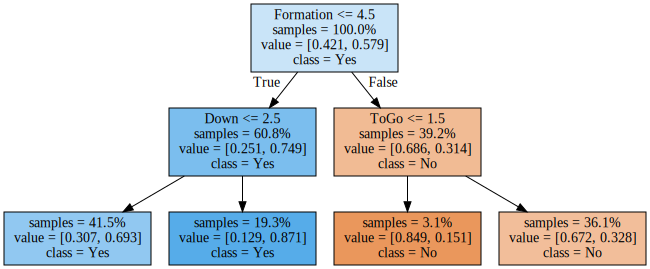

In [ ]:
# shallow decision tree plot to check for obvious leakage
bl_visual = export_graphviz(model, out_file=None,
                           feature_names=Xcols,
                           class_names=['No', 'Yes'], filled=True,
                           impurity=False, proportion=True)

graphviz.Source(bl_visual)

### Baseline Analysis

Formation may not be able to confirm a Pass as absolute, but it appears to have a lot of predictive power in saying what IS NOT Pass potential. I'm also pleased that right out the gate, my baseline is 69.45%, compared to the majority baseline of 58%. From here, I'll check some of our datetime columns to see what relevance they have, before making my list of features for testing different model types.

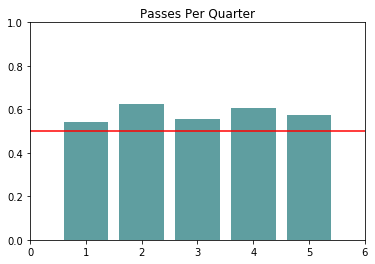

In [ ]:
x = sorted(df['Quarter'].unique())
y = [df[df['Quarter'] == (i + 1)]['IsPass'].mean() for i in range(len(x))]
plt.bar(x, y, color='cadetblue')
plt.axhline(0.5, color='red')
plt.xlim(0,6)
plt.ylim(0,1)
plt.title("Passes Per Quarter")
plt.show()

### Observations

* More passes are thrown in the second & fourth quarters
* Second quarter: important for morale to keep game winnable/increase lead; depending on which team gets the kickoff, chunk plays can become more valuable
* Fourth quarter: One team is usually playing catch-up to stay in the game, more passes & faster pace; defense may be playing conservative, giving up pass plays for clock management purposes

### **Pass Per Quarter Analysis**

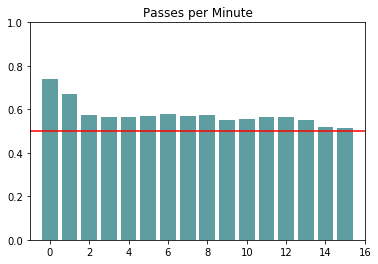

In [ ]:
x = sorted(df['Minute'].unique())
y = [df[df['Minute'] == m]['IsPass'].mean() for m in x]
plt.bar(x, y, color='cadetblue')
plt.axhline(0.5, color='red')
plt.xlim(-1, 16)
plt.ylim(0, 1)
plt.title("Passes per Minute")
plt.show()

### Observations:

* Passes become more likely as game goes on
* The run game is used to establish the pass game; this graph reflects that
* More runs comparatively early in the quarter, transitioning to more passes

###  **Passes Per Minute Analysis**

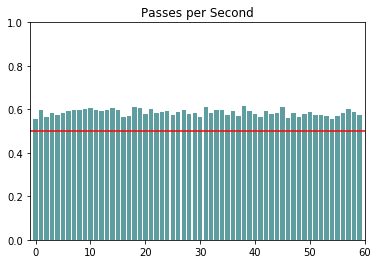

In [ ]:
x = sorted(df['Second'].unique())
y = [df[df['Second'] == s]['IsPass'].mean() for s in x]
plt.bar(x, y, color='cadetblue')
plt.axhline(0.5, color='red')
plt.xlim(-1, 60)
plt.ylim(0, 1)
plt.title('Passes per Second')
plt.show()

### Observations:

* Not really any predictive power in the Seconds field
* The way the clock flows and the level that game decisions are made dictate that the actual second on the clock is rarely important
* Normal flow of games, whether high or low tempo, render the Seconds field essentially random

### **Passes Per Yardline Analysis**

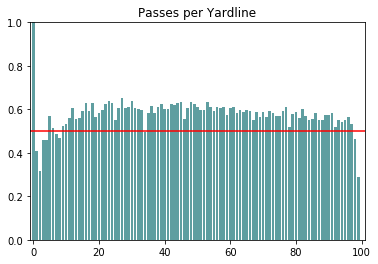

In [ ]:
x = sorted(df['YardLine'].unique())
y = [df[df['YardLine'] == s]['IsPass'].mean() for s in x]
plt.bar(x, y, color='cadetblue')
plt.axhline(0.5, color='red')
plt.xlim(-1, 101)
plt.ylim(0, 1)
plt.title("Passes per Yardline")
plt.show()

### Observations:

* Rushes dominate just outside your own endzone & inside the redzone; otherwise the rate of passing stays about constant
* Outside your endzone: Your primary concern is not getting sacked in the endzone for a safety; you don't want the quarterback hanging out back there, so you call fewer passes, and rushing allows you to try to break out of the close quarters more quickly
* Inside the redzone: Interceptions are more likely in the redzone; rushes are more consistently successful for low-yardage situations; the passing playbook is restricted by the lack of distance

## **Model Testing**

---
### Random Forest Classifier Model

In [ ]:
# random forest model
pipeline = Pipeline([('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
roc_auc_score(y_test, y_pred)

0.67757841553129

In [ ]:
# random forest validation
#pipeline.score(y_val, pipeline.predict(X_val))
roc_auc_score(y_val, pipeline.predict(X_val))

0.6810592736328971

### Observations:
**Baseline Model:** 0.6944560491075563

**Test:** 0.6767394352053937

**Vaidation:** 0.6834371774192517

---
## XGBOOST Classifier Model







In [ ]:
# xgboost model
pipeline = make_pipeline(XGBClassifier())
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.7194436505668286

In [ ]:
# xgboost validation
pipeline.score(X_val, y_val)

0.719021902190219

### Observations:
**Baseline Model:** 0.6944560491075563

**Test:** 0.7194436505668286

**Vaidation:** 0.719021902190219

# Feature Engineering

My goal was to create features that showcased the situations a team had to take into consideration when choosing whether or not to Pass or Rush the ball.

My features:
* Was a Pass attempted in the last play attempt? (0/1)
* Was a Pass successfully completed in the last play? (0/1)
* How many seconds were left total before the end of the game? (numeric)
* What Division was the Team in (Categorical)

In [ ]:
#columns: organize, sort top to bottom (sans time, obviously)
df = df.sort_values(['GameId', 'Quarter', 'Minute', 'Second', 'Down'], ascending=[True, True, False, False, True])
bucket1 = []
bucket2 = []
#uses unique value of GameID to hone in on Plays specifically
for g in df['GameId'].unique():
  plays = df[df['GameId'] == g]
  ispass = (plays['IsPass'] == 1).map(lambda x: 1 if x else 0)
  iscomp = (plays['IsIncomplete'] == 0).map(lambda x: 1 if x else 0)
  vals = ispass.tolist()
  vals.insert(0, 0)
  vals = vals[:-1]
  bucket1 += vals
  vals = iscomp.tolist()
  vals.insert(0, 0)
  vals = vals[:-1]
  bucket2 += vals
df['AfterPass'] = bucket1
df['AfterComp'] = bucket2
df.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,AfterPass,AfterComp
679,2017090700,2017-09-07,1,14,55,20.0,15,1,10,27,0,0,2017,0,5.0,7.0,0,1,1,0,2.0,0,0,0,NaN,0,0,0,0,0,0,NaN,27,1,0,NaN,0,NaN,0,0,0
680,2017090700,2017-09-07,1,14,49,20.0,15,2,10,27,0,0,2017,8,5.0,7.0,0,1,0,0,13.0,0,0,0,NaN,0,0,0,0,0,0,NaN,27,1,0,NaN,0,NaN,0,1,0
681,2017090700,2017-09-07,1,14,14,20.0,15,3,2,35,1,0,2017,8,4.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,2.0,35,1,0,NaN,0,NaN,0,1,1
682,2017090700,2017-09-07,1,13,52,20.0,15,1,10,43,0,0,2017,3,2.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0.0,43,1,0,NaN,0,NaN,0,0,1
683,2017090700,2017-09-07,1,13,26,20.0,15,2,7,46,1,0,2017,19,2.0,7.0,0,1,0,0,2.0,0,0,0,NaN,0,0,0,0,0,0,NaN,46,1,0,NaN,0,NaN,0,0,1


In [ ]:
#Divisions
divs = {
    'CHI': 'nn',
    'GB': 'nn',
    'LA': 'nw',
    'CAR': 'ns',
    'TEN': 'as',
    'CLE': 'an',
    'JAX': 'as',
    'KC': 'aw',
    'MIA': 'ae',
    'BAL': 'an',
    'MIN': 'nn',
    'ATL': 'ns',
    'NYJ': 'ae',
    'BUF': 'ae',
    'PHI': 'ne',
    'WAS': 'ne',
    'IND': 'as',
    'LAC': 'aw',
    'SEA': 'nw',
    'CIN': 'an',
    'ARI': 'nw',
    'DET': 'nn',
    'NYG': 'ne',
    'DAL': 'ne',
    'SF': 'nw',
    'TB': 'ns',
    'PIT': 'an',
    'NE': 'ae',
    'NO': 'ns',
    'HOU': 'as',
    'DEN': 'aw',
    'OAK': 'aw'
}
newdivs = {}
keys = sorted(divs.keys())
for i in range(len(keys)):
  newdivs[i] = divs[keys[i]]

# 0 - division game
# 1 - conference game
# 2 - all others
bucket = []
for r in df.itertuples():
  if np.isnan(getattr(r, 'OffenseTeam')):
    bucket.append(float('nan'))
  else:
    offdiv = newdivs[getattr(r, 'OffenseTeam')]
    defdiv = newdivs[getattr(r, 'DefenseTeam')]
    if offdiv == defdiv:
      bucket.append(0)
    elif offdiv[0] == defdiv[0]:
      bucket.append(1)
    else:
      bucket.append(2)
df['divtype'] = bucket
df.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,AfterPass,AfterComp,divtype
679,2017090700,2017-09-07,1,14,55,20.0,15,1,10,27,0,0,2017,0,5.0,7.0,0,1,1,0,2.0,0,0,0,NaN,0,0,0,0,0,0,NaN,27,1,0,NaN,0,NaN,0,0,0,1.0
680,2017090700,2017-09-07,1,14,49,20.0,15,2,10,27,0,0,2017,8,5.0,7.0,0,1,0,0,13.0,0,0,0,NaN,0,0,0,0,0,0,NaN,27,1,0,NaN,0,NaN,0,1,0,1.0
681,2017090700,2017-09-07,1,14,14,20.0,15,3,2,35,1,0,2017,8,4.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,2.0,35,1,0,NaN,0,NaN,0,1,1,1.0
682,2017090700,2017-09-07,1,13,52,20.0,15,1,10,43,0,0,2017,3,2.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0.0,43,1,0,NaN,0,NaN,0,0,1,1.0
683,2017090700,2017-09-07,1,13,26,20.0,15,2,7,46,1,0,2017,19,2.0,7.0,0,1,0,0,2.0,0,0,0,NaN,0,0,0,0,0,0,NaN,46,1,0,NaN,0,NaN,0,0,1,1.0


In [ ]:
df['SecsLeft'] = 60 * df['Minute'] + df['Second'] + 15 * 60 * (4 - df['Quarter'])
df.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,AfterPass,AfterComp,divtype,SecsLeft
679,2017090700,2017-09-07,1,14,55,20.0,15,1,10,27,0,0,2017,0,5.0,7.0,0,1,1,0,2.0,0,0,0,NaN,0,0,0,0,0,0,NaN,27,1,0,NaN,0,NaN,0,0,0,1.0,3595
680,2017090700,2017-09-07,1,14,49,20.0,15,2,10,27,0,0,2017,8,5.0,7.0,0,1,0,0,13.0,0,0,0,NaN,0,0,0,0,0,0,NaN,27,1,0,NaN,0,NaN,0,1,0,1.0,3589
681,2017090700,2017-09-07,1,14,14,20.0,15,3,2,35,1,0,2017,8,4.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,2.0,35,1,0,NaN,0,NaN,0,1,1,1.0,3554
682,2017090700,2017-09-07,1,13,52,20.0,15,1,10,43,0,0,2017,3,2.0,11.0,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0.0,43,1,0,NaN,0,NaN,0,0,1,1.0,3532
683,2017090700,2017-09-07,1,13,26,20.0,15,2,7,46,1,0,2017,19,2.0,7.0,0,1,0,0,2.0,0,0,0,NaN,0,0,0,0,0,0,NaN,46,1,0,NaN,0,NaN,0,0,1,1.0,3506


In [ ]:
len(descs.unique())

99140

---
# Model Function





In [ ]:
###PUT ALL MODEL CODE IN THIS SECTION###
Xcols2 = Xcols + ['AfterPass', 'AfterComp', 'divtype', 'SecsLeft']

df_2017 = df[df['GameDate'] < datetime.datetime(2018, 7, 1)]
df_2018 = df[(df['GameDate'] > datetime.datetime(2018, 7, 1)) &
             (df['GameDate'] < datetime.datetime(2019, 7, 1))].dropna(subset=['divtype'])
df_2019 = df[df['GameDate'] > datetime.datetime(2019, 7, 1)].dropna(subset=['OffenseTeam'])

X_train = df_2017[Xcols2]
X_test = df_2018[Xcols2]
X_val = df_2019[Xcols2]
y_train = df_2017[ycol]
y_test = df_2018[ycol]
y_val = df_2019[ycol]

lr_pipeline = Pipeline([('lr', LogisticRegression(solver='lbfgs', max_iter=1000))])
dt1_pipeline = Pipeline([('dt', DecisionTreeClassifier(max_depth=3))])
dt2_pipeline = Pipeline([('dt', DecisionTreeClassifier(max_depth=6))])
rf1_pipeline = Pipeline([('rf', RandomForestClassifier(max_depth=3, n_estimators=100, n_jobs=-1))])
rf2_pipeline = Pipeline([('rf', RandomForestClassifier(max_depth=None, n_estimators=100, n_jobs=-1))])
xg_pipeline = Pipeline([('xgb', XGBClassifier(max_depth=3, n_estimators=100, n_jobs=-1))])

lr_pipeline.fit(X_train, y_train)
dt1_pipeline.fit(X_train, y_train)
dt2_pipeline.fit(X_train, y_train)
rf1_pipeline.fit(X_train, y_train)
rf2_pipeline.fit(X_train, y_train)
xg_pipeline.fit(X_train, y_train)

print('Logistic Regression Test Score:\n', roc_auc_score(y_test, lr_pipeline.predict(X_test)))
print('Decision Tree w/ Max Depth of 3 Test Score:\n',  roc_auc_score(y_test, dt1_pipeline.predict(X_test)))
print('Decision Tree w/ Max Depth of 6+9 Test Score:\n',  roc_auc_score(y_test, dt2_pipeline.predict(X_test)))
print('Random Forest w/ Max Depth of 3 Test Score:\n',  roc_auc_score(y_test, rf1_pipeline.predict(X_test)))
print('Random Forest w/ Max Depth of None Test Score:\n',  roc_auc_score(y_test, rf2_pipeline.predict(X_test)))
print('XGBoost Classifier Test Score:\n',  roc_auc_score(y_test, xg_pipeline.predict(X_test)))

Logistic Regression Test Score:
 0.6656345904211673
Decision Tree w/ Max Depth of 3 Test Score:
 0.6982137533457571
Decision Tree w/ Max Depth of 6+9 Test Score:
 0.700117170792465
Random Forest w/ Max Depth of 3 Test Score:
 0.6944779231113526
Random Forest w/ Max Depth of None Test Score:
 0.6820352625353688
XGBoost Classifier Test Score:
 0.702726343430344


In [ ]:
print('Logistic Regression Validation Score:\n', roc_auc_score(y_val, lr_pipeline.predict(X_val)))
print('Decision Tree w/ Max Depth of 3 Validation Score:\n',  roc_auc_score(y_val, dt1_pipeline.predict(X_val)))
print('Decision Tree w/ Max Depth of 6 Validation Score:\n',  roc_auc_score(y_val, dt2_pipeline.predict(X_val)))
print('Random Forest w/ Max Depth of 3 Validation Score:\n',  roc_auc_score(y_val, rf1_pipeline.predict(X_val)))
print('Random Forest w/ Max Depth of None Validation Score:\n',  roc_auc_score(y_val, rf2_pipeline.predict(X_val)))
print('XGBoost Classifier Validation Score:\n',  roc_auc_score(y_val, xg_pipeline.predict(X_val)))

Logistic Regression Validation Score:
 0.6750816601131768
Decision Tree w/ Max Depth of 3 Validation Score:
 0.696265775197588
Decision Tree w/ Max Depth of 6 Validation Score:
 0.7006957867585195
Random Forest w/ Max Depth of 3 Validation Score:
 0.6925807908391699
Random Forest w/ Max Depth of None Validation Score:
 0.6882154499610474
XGBoost Classifier Validation Score:
 0.7016009553209095


## Model Analysis

* Logistic Regression Validation Score:

 0.6750816601131768
* Decision Tree w/ Max Depth of 3 Validation Score:

 0.696265775197588
* **Decision Tree w/ Max Depth of 6 Validation Score:**

 **0.7007872445964561**
* Random Forest w/ Max Depth of 3 Validation Score:

 0.692401411114299
* Random Forest w/ Max Depth of None Validation Score:

 0.6887598817326746
* **XGBoost Classifier Validation Score:**

 **0.7016009553209095**

 I tuned the Decision Tree w/ Max Depth from 3 up to 7 max_depth. 7 ended up dropping in accuracy, but 6 gave me above 70%. Success!

 No surprise, Gradient Boosting ended up being my MVP model.

 Next: Create Visualizations to check individual predictions for Pass or Not a Pass.


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(dt2_pipeline.named_steps['dt'])
shap_values = explainer.shap_values(randompass)
shap.force_plot(explainer.expected_value[0], shap_values[0], randompass)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(dt2_pipeline.named_steps['dt'])
shap_values = explainer.shap_values(randomrush)
shap.force_plot(explainer.expected_value[0], shap_values[0], randomrush)

---
## Model Visualizations


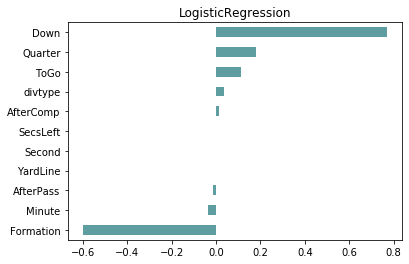

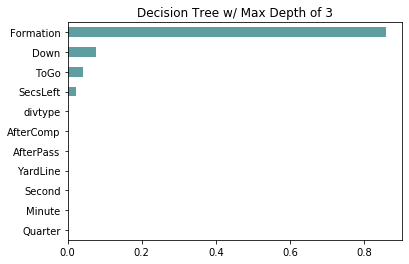

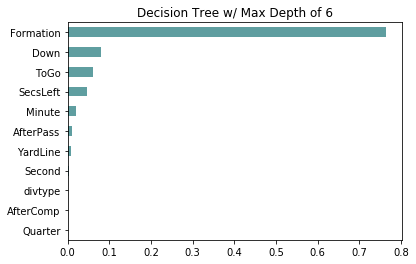

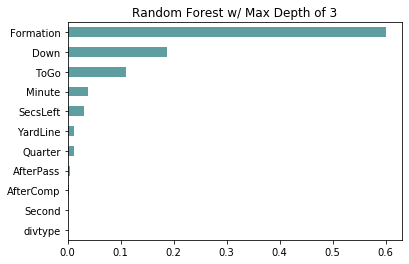

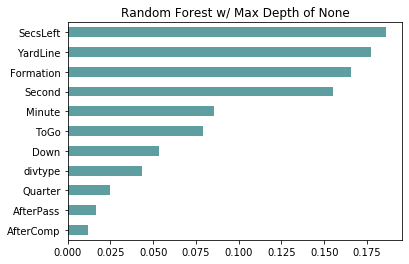

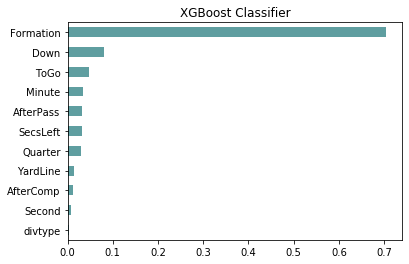

In [ ]:
pd.Series(lr_pipeline.named_steps['lr'].coef_[0], X_val.columns).sort_values().plot.barh(color='cadetblue', title='LogisticRegression')
plt.show()
models = [dt1_pipeline, dt2_pipeline, rf1_pipeline, rf2_pipeline, xg_pipeline]
refs = ['dt', 'dt', 'rf', 'rf', 'xgb']
titles = ['Decision Tree w/ Max Depth of 3',
          'Decision Tree w/ Max Depth of 6',
          'Random Forest w/ Max Depth of 3',
          'Random Forest w/ Max Depth of None',
          'XGBoost Classifier']
for i in range(len(models)):
  imports = pd.Series(models[i].named_steps[refs[i]].feature_importances_, X_val.columns)
  imports.sort_values().plot.barh(color='cadetblue', title=titles[i])
  plt.show()

---
# Conclusion:

The Offense can take comfort in knowing that their Formation isn't completely predictive as far as Pass opportunity, but it certainly has a lot of capability to show your strategy. Quarterbacks show pressure during 3rd and 4th Downs. Most of the Features I engineered may not have improved my model, but they absolutely gave me further insight into how I have to adjust what data I give to the algorithm. The strategy happening in real time consists of instinct, snap-second positions, and consistently takes into consideration a measure of the opponents and their strengths and weaknesses. The question is, how can I quantify the thoughts going through the quarterbacks mind? Sounds like I'll just have to settle on down with a few quarterbacks, show them slides of completed and failed passes, and situations where they chose to Rush instead, and have them walk me through their decision making process! Jared Goff, give me a call!

---
Next Steps

Below is an ongoing list of the Future Features I'd like to engineer as I iterate through the rest of the 2019 Season.

* Conservative Clock Management (If they have more time on the clock to experiment, or if they're crunched for time)

* Obvious Passing Situations

* Quantify Pre-Snap Injuries

* Quantify importance of positions on the field in completing a pass.